<a href="https://colab.research.google.com/github/AustinHouston/atomai/blob/master/examples/rVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rotationally-invariant VAE: Application to arbitrary rotated 2D images


---

This notebook demonstrates how to apply a rotationally-invariant variational autoencoder (VAE) to the arbitrary rotated images of handwritten digits.

---



Prepared by Maxim Ziatdinov

E-mail: ziatdinovmax@gmail.com

In [1]:
#@title Installation
# Install the latest version from source
# (or you may instal a stable version from PyPi instead with !pip install pyroved)
!pip install -q git+https://github.com/ziatdinovmax/pyroved.git
# install Kornia library (for image transformations)
!pip install -q kornia

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 73.6 MB/s eta 0:00:00


In [2]:
#@title Imports
from typing import Tuple

import pyroved as pv
import torch
import kornia as K
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns

tt = torch.tensor

In [3]:
#@title Helper functions
def rotate_images(imgdata, rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    torch.manual_seed(0)
    theta = torch.randint(*rotation_range, size=(len(imgdata),))
    imgdata = K.geometry.rotate(imgdata.float()[:, None], theta.float())
    imgdata = imgdata / imgdata.max()
    return imgdata, theta


def get_mnist_data(rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    !wget -qq www.di.ens.fr/~lelarge/MNIST.tar.gz
    !tar -zxf MNIST.tar.gz
    mnist_trainset = datasets.MNIST(
        root='.', train=True, download=False, transform=None)
    images_r, theta = rotate_images(mnist_trainset.data, rotation_range)
    return images_r, pv.utils.to_onehot(mnist_trainset.targets, 10), theta

Get training data and create a dataloader object:

In [7]:
train_data, train_labels, angles = get_mnist_data(rotation_range=[-60, 61])
train_loader = pv.utils.init_dataloader(train_data, batch_size=800)

In [64]:
train_data.shape

torch.Size([60000, 1, 28, 28])

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import numpy as np
data = np.load('/content/drive/MyDrive/particle_crops.npz')['imstack']

In [51]:
data = data.astype(np.float32)

In [52]:
data_torch = torch.from_numpy(data)
data_torch = data_torch.unsqueeze(dim=1)
data_torch.shape

torch.Size([112669, 1, 25, 25])

In [56]:
train_loader = pv.utils.init_dataloader(data_torch, batch_size=800)

In [57]:
# fig, axes = plt.subplots(10, 10, figsize=(8, 8),
#                          subplot_kw={'xticks':[], 'yticks':[]},
#                          gridspec_kw=dict(hspace=0.1, wspace=0.1))

# for ax, im, lbl in zip(axes.flat, train_data, train_labels):
#     ax.imshow(im.squeeze(), cmap='binary', interpolation='nearest')
#     ax.text(0.05, 0.05, str(lbl.argmax().item()),
#             transform=ax.transAxes, color='green')

First, we explore the simple VAE:

In [58]:
in_dim = (25, 25)

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
vae = pv.models.iVAE(in_dim, latent_dim=2, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 385.2373
Epoch: 2 Training loss: 381.1321
Epoch: 3 Training loss: 380.9775
Epoch: 4 Training loss: 380.9091
Epoch: 5 Training loss: 380.8862
Epoch: 6 Training loss: 380.8770
Epoch: 7 Training loss: 380.8636
Epoch: 8 Training loss: 380.8525
Epoch: 9 Training loss: 380.8736
Epoch: 10 Training loss: 380.8558
Epoch: 11 Training loss: 380.8461
Epoch: 12 Training loss: 380.8533
Epoch: 13 Training loss: 380.8485
Epoch: 14 Training loss: 380.8375
Epoch: 15 Training loss: 380.8479
Epoch: 16 Training loss: 380.8581
Epoch: 17 Training loss: 380.8498
Epoch: 18 Training loss: 380.8389
Epoch: 19 Training loss: 380.8444
Epoch: 20 Training loss: 380.8465
Epoch: 21 Training loss: 380.8332
Epoch: 22 Training loss: 380.8481
Epoch: 23 Training loss: 380.8285
Epoch: 24 Training loss: 380.8397
Epoch: 25 Training loss: 380.8388
Epoch: 26 Training loss: 380.8271
Epoch: 27 Training loss: 380.8260
Epoch: 28 Training loss: 380.8354
Epoch: 29 Training loss: 380.8680
Epoch: 30 Training loss

Visualize the learned latent manifold:

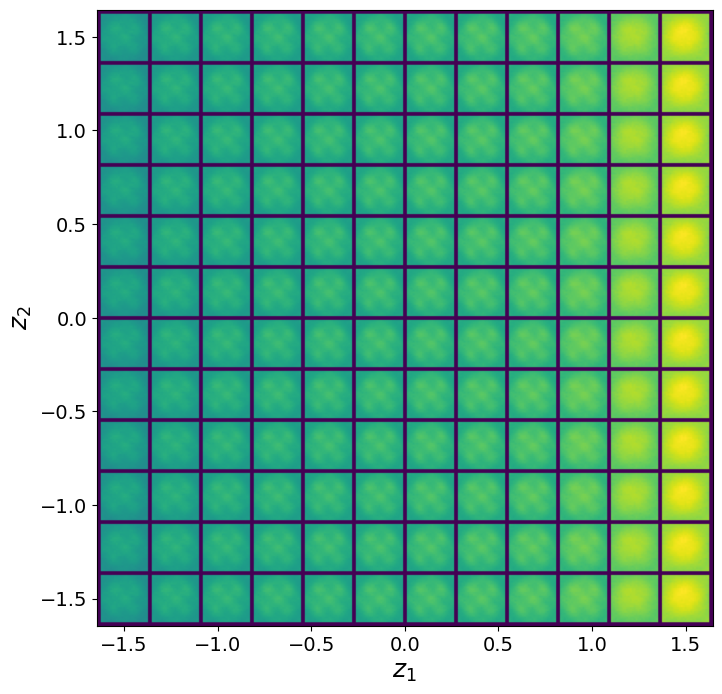

In [59]:
vae.manifold2d(d=12, cmap='viridis');

Encode all the data and view the encoded values as a scatter plot:

/tmp/ipython-input-1436995903.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  im1 = ax1.scatter(z_mean[:,-1], z_mean[:,-2], s=1, cmap='gnuplot2')
/tmp/ipython-input-1436995903.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  im2 = ax2.scatter(z_mean[:,-1], z_mean[:,-2], s=1, cmap='jet')


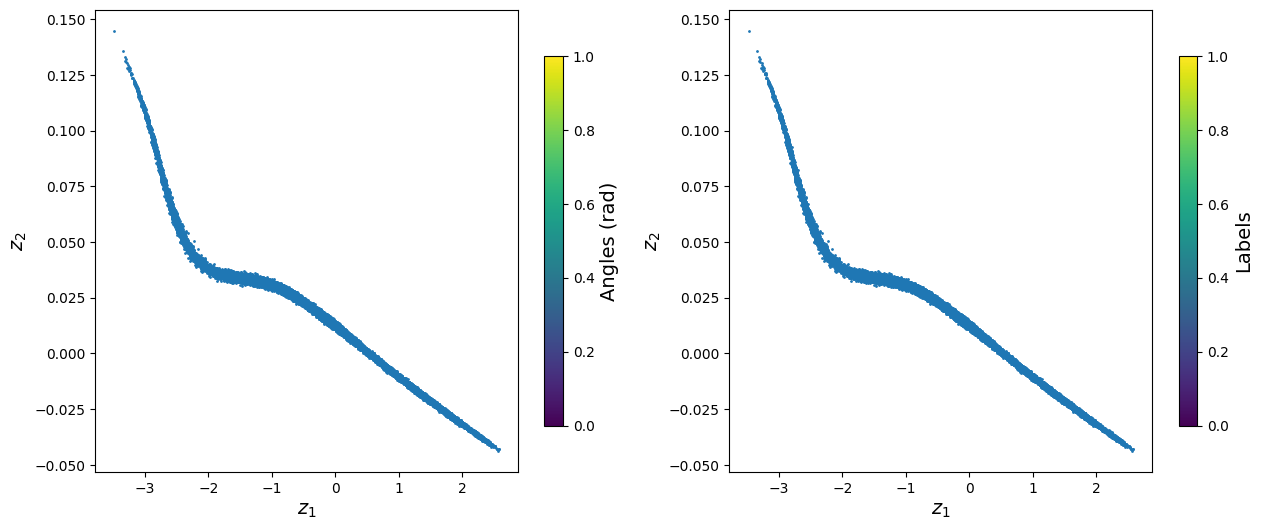

In [65]:
z_mean, z_sd = vae.encode(data_torch)
# _, labels = torch.max(train_labels, 1)
# labels = labels.cpu().tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,-1], z_mean[:,-2], s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,-1], z_mean[:,-2], s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

The examination of latent space shows that the angle changes along the first latent direction, whereas the digit changes mostly along the second latent dimension. This clearly illustrates the disentanglement of the data representation concept, where the rotational angle and class emerge as the two most prominent factors of variation within the data.

Now let's train VAE with rotational invariance (aka rVAE):

In [66]:
# Reinitialize dataloader
train_loader = pv.utils.init_dataloader(data_torch, batch_size=800)

In [67]:
in_dim = (25,25)

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
rvae = pv.models.iVAE(in_dim, latent_dim=2, invariances=['r'], seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(rvae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader, scale_factor=3)
    trainer.print_statistics()

Epoch: 1 Training loss: 385.2584
Epoch: 2 Training loss: 383.1379
Epoch: 3 Training loss: 382.4919
Epoch: 4 Training loss: 382.4777
Epoch: 5 Training loss: 382.4239
Epoch: 6 Training loss: 382.4253
Epoch: 7 Training loss: 382.3828
Epoch: 8 Training loss: 382.4327
Epoch: 9 Training loss: 382.3903
Epoch: 10 Training loss: 382.4080
Epoch: 11 Training loss: 382.4126
Epoch: 12 Training loss: 382.4161
Epoch: 13 Training loss: 382.3778
Epoch: 14 Training loss: 382.3668
Epoch: 15 Training loss: 382.3706
Epoch: 16 Training loss: 382.4059
Epoch: 17 Training loss: 382.3659
Epoch: 18 Training loss: 382.3838
Epoch: 19 Training loss: 382.3520
Epoch: 20 Training loss: 382.3619
Epoch: 21 Training loss: 382.3579
Epoch: 22 Training loss: 382.3545
Epoch: 23 Training loss: 382.3908
Epoch: 24 Training loss: 382.3697
Epoch: 25 Training loss: 382.3494
Epoch: 26 Training loss: 382.3762
Epoch: 27 Training loss: 382.3638
Epoch: 28 Training loss: 382.3790
Epoch: 29 Training loss: 382.3430
Epoch: 30 Training loss

Visualize the learned latent manifold:

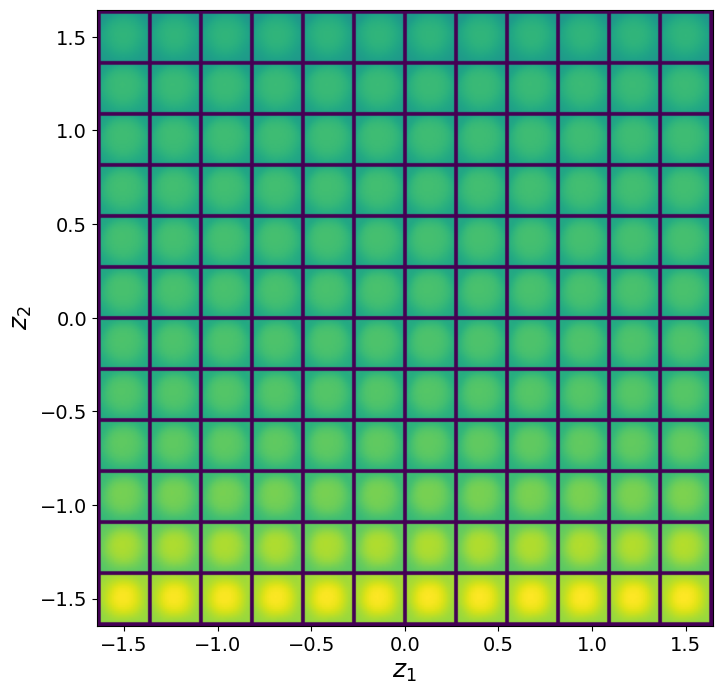

In [68]:
rvae.manifold2d(d=12, cmap='viridis');

Encode all the data and view the encoded values as a scatter plot:

(array([  819.,  8191., 10695., 15030., 65963.,  9356.,   523.,   462.,
          488.,  1142.]),
 array([-0.09113187, -0.07953969, -0.06794752, -0.05635535, -0.04476318,
        -0.03317101, -0.02157883, -0.00998666,  0.00160551,  0.01319768,
         0.02478985]),
 <BarContainer object of 10 artists>)

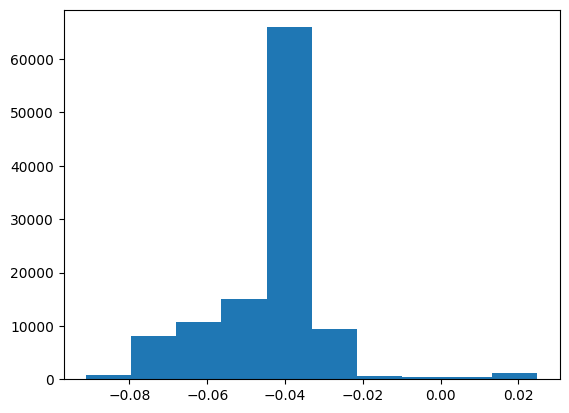

In [73]:
plt.figure()
plt.hist(z_mean[:,0])

/tmp/ipython-input-1645658281.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  im1 = ax1.scatter(z_mean[:,-1], z_mean[:,-2], s=1, cmap='gnuplot2')
/tmp/ipython-input-1645658281.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  im2 = ax2.scatter(z_mean[:,-1], z_mean[:,-2], s=1, cmap='jet')


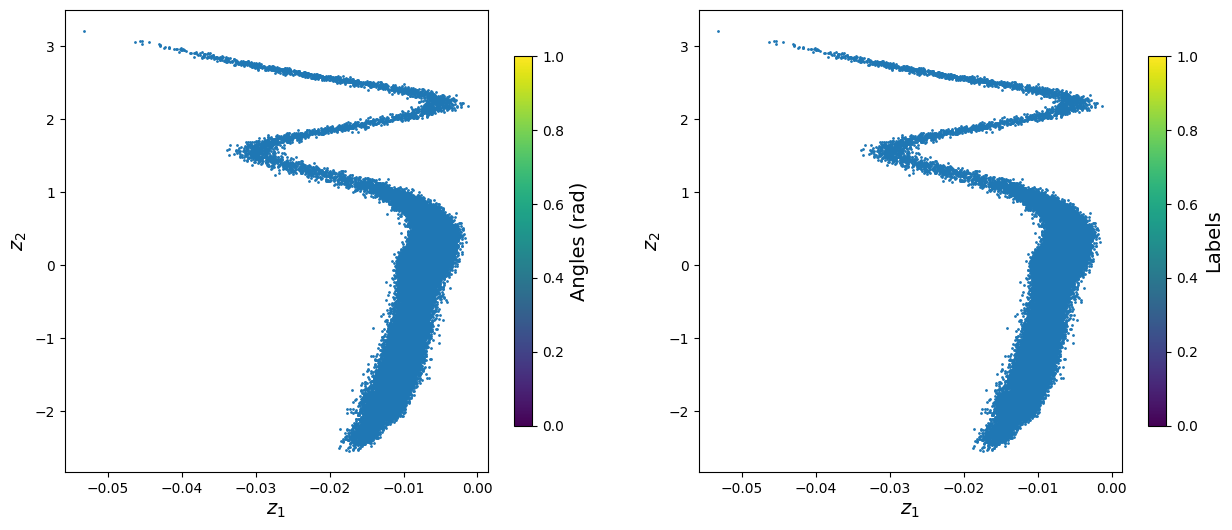

In [71]:
z_mean, z_sd = rvae.encode(data_torch)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,-1], z_mean[:,-2], s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,-1], z_mean[:,-2], s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

In this case, the digits in the latent space are oriented in one direction. The latent space shows that the angles are now random, whereas the digits form well-defined clusters (rather remarkable given that we encode the data set using only two latent variables). We also get the angle as one of the latent variables, and the latent angle and ground truth angle are compared in the figure above. Note that they are linearly related, but at the same time latent angles have broad distribution. This is unsurprising since an angle is one of the characteristics of handwriting style and varies from person to person! The latent representation we discovered hence compensated by this fact via introducing it as an additional augmentation variable, and then separating it from other factors of variation.


ValueError: All arrays must be of the same length

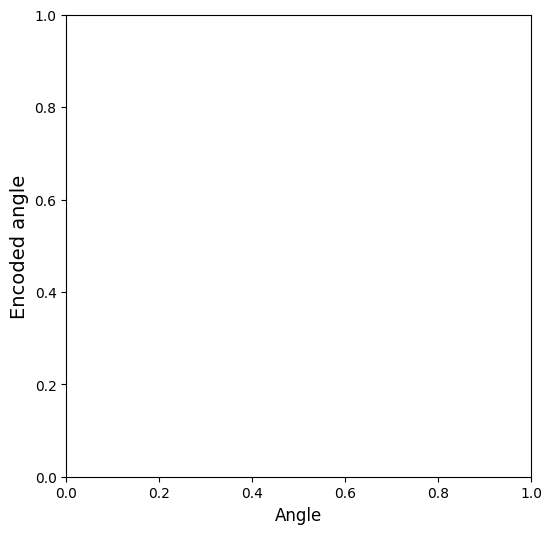

In [72]:
plt.figure(figsize=(6, 6))
plt.xlabel("Angle", fontsize=12)
plt.ylabel("Encoded angle", fontsize=14)
ax = sns.histplot(x=torch.deg2rad(angles.float()), y=z_mean[:, 0], bins=50, pthresh=.1);

Finally, we illustrate the class-conditioned rVAE (crVAE) applied to this data set. Note that the only two things we have to do is add labels to our data loader and specify number of classes (as ```c_dim```) when initializing the crVAE model - pyroVED will take care of the rest.

In [ ]:
# Initialize dataloader (here we are adding labels to the training data)
train_loader = pv.utils.init_dataloader(train_data, train_labels, batch_size=200)

In [ ]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
crvae = pv.models.iVAE(in_dim, latent_dim=2, c_dim=10, invariances=['r'], seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(crvae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader, scale_factor=3)
    trainer.print_statistics()

Epoch: 1 Training loss: 242.8365
Epoch: 2 Training loss: 191.3299
Epoch: 3 Training loss: 179.6475
Epoch: 4 Training loss: 173.5737
Epoch: 5 Training loss: 169.2958
Epoch: 6 Training loss: 166.4848
Epoch: 7 Training loss: 163.6232
Epoch: 8 Training loss: 162.1406
Epoch: 9 Training loss: 161.2008
Epoch: 10 Training loss: 160.3955
Epoch: 11 Training loss: 159.6946
Epoch: 12 Training loss: 159.1265
Epoch: 13 Training loss: 158.7559
Epoch: 14 Training loss: 158.2375
Epoch: 15 Training loss: 157.9815
Epoch: 16 Training loss: 157.6312
Epoch: 17 Training loss: 157.3326
Epoch: 18 Training loss: 156.9870
Epoch: 19 Training loss: 156.7250
Epoch: 20 Training loss: 156.6542
Epoch: 21 Training loss: 156.3124
Epoch: 22 Training loss: 155.9762
Epoch: 23 Training loss: 155.7882
Epoch: 24 Training loss: 155.6232
Epoch: 25 Training loss: 155.3236
Epoch: 26 Training loss: 155.3034
Epoch: 27 Training loss: 154.9580
Epoch: 28 Training loss: 154.7319
Epoch: 29 Training loss: 154.6854
Epoch: 30 Training loss

View the learned latent manifold for each class:

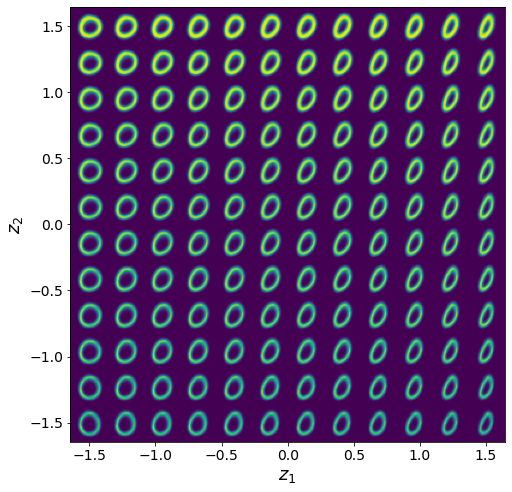

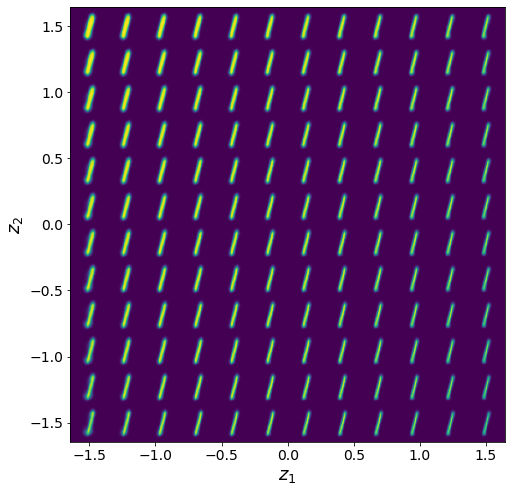

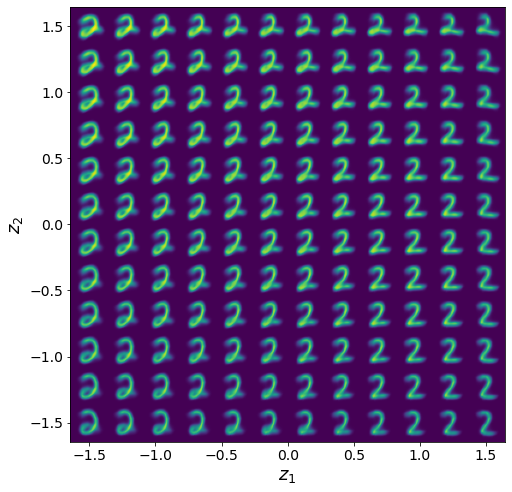

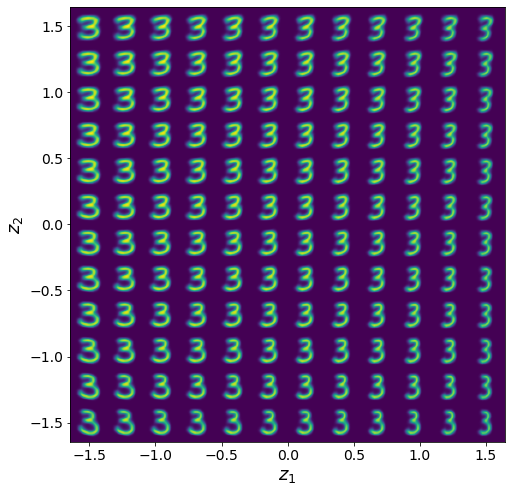

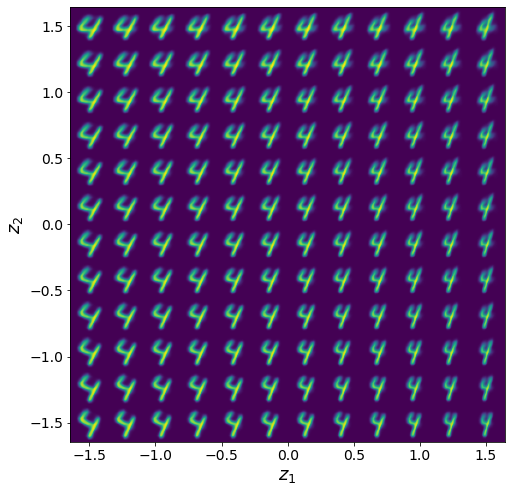

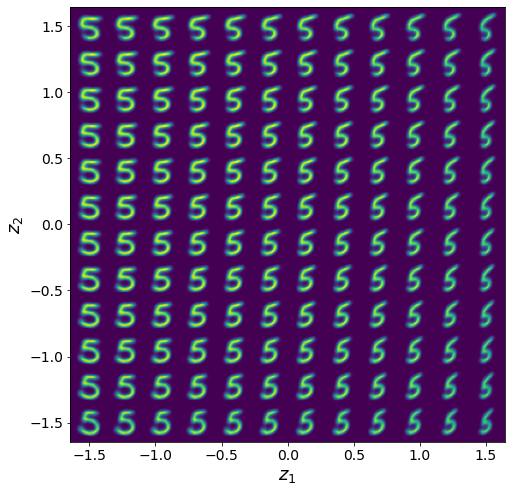

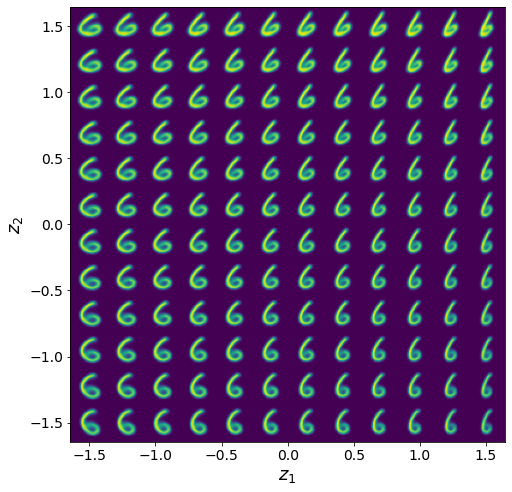

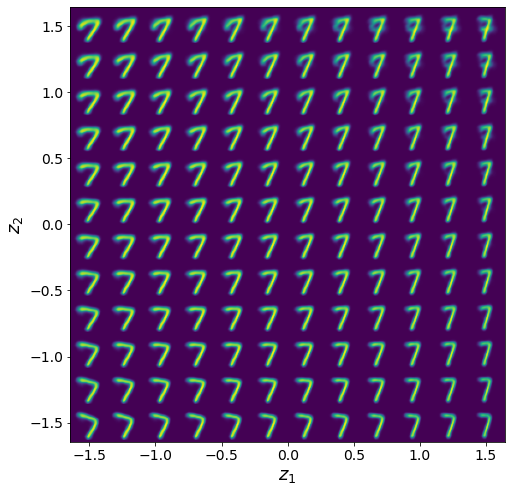

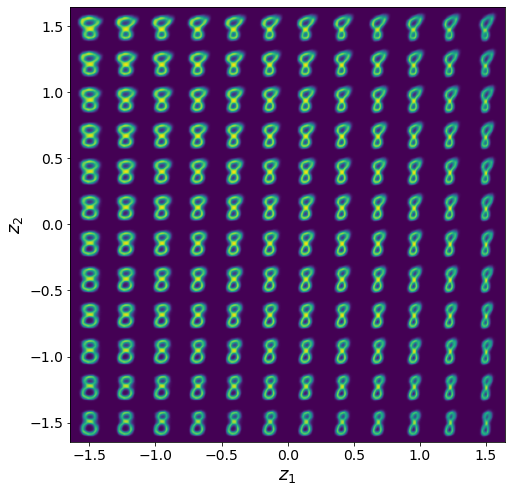

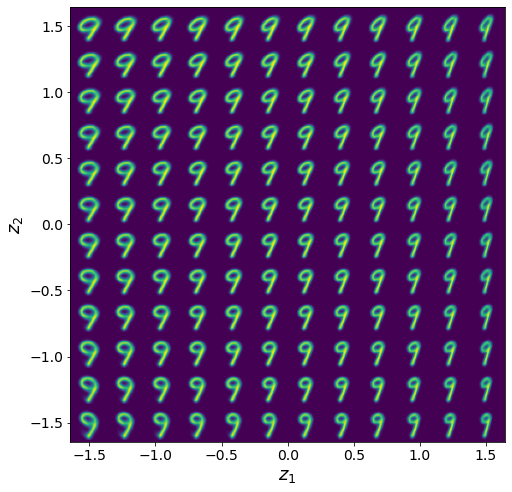

In [ ]:
for cls in range(10):
    cls = pv.utils.to_onehot(tt([cls,]), 10)
    crvae.manifold2d(d=12, y=cls, cmap="viridis")

In this case, our latent reconstructions clearly show that within each latent space, the digits are oriented in the same direction, and latent variables now encode very subtle details of the handwriting styles.

Encode all the data and view the encoded values as a scatter plot:

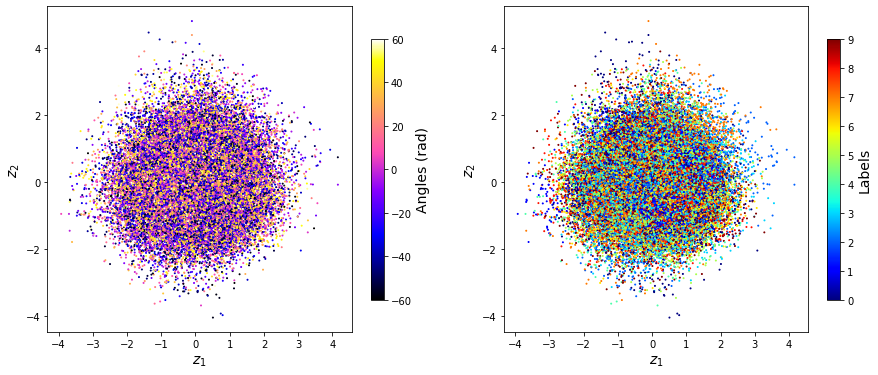

In [ ]:
z_mean, z_sd = crvae.encode(train_data, train_labels)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10)